In [1]:
import pdal
import json
import numpy as np
import geopandas as gpd
import pandas as pd

In [2]:
%load_ext autotime

In [3]:
areas_estudo = gpd.read_file("./gis/locais-selecionados.gpkg", layer='locais-selecionados')

time: 19.4 ms


In [4]:
areas_estudo

,Nome,Lote,Autoria,Ano de Construção,Nome Oficial,geometry
0,Casa Modernista,042.029.0021,Gregori Warchavchik,1928.0,Casa Modernista da Rua Santa Cruz,"POLYGON ((333309.176 7389518.129, 333308.290 7..."
1,Oca,None,Oscar Niemeyer,1954.0,Pavilhão Lucas Nogueira Garcez,"POLYGON ((331023.350 7390484.674, 331023.350 7..."
2,Biblioteca Latino Americana,None,Oscar Niemeyer,1989.0,Biblioteca Latino-Americana Victor Civita,"POLYGON ((329902.822 7397074.728, 330006.485 7..."
3,Colégio Caetano de Campos,None,Ramos de Azevedo,1894.0,Edifício Caetano de Campos,"POLYGON ((332159.584 7395288.375, 332240.211 7..."
4,Copan,006.064.0000-06,Oscar Niemeyer,1966.0,Edifício Copan,"POLYGON ((332136.454 7395027.000, 332141.387 7..."
5,Martinelli,001.072.0000-01,Vilmos (William) Fillinger,1934.0,Edifício Martinelli,"POLYGON ((333062.581 7395130.320, 333068.549 7..."
6,Banespão,001.074.0002,Plínio Botelho do Amaral,1947.0,Edifício Altino Arantes,"POLYGON ((333246.947 7395112.386, 333249.292 7..."
7,Faculdade de Direito São Francisco,005.013.0007,Ricardo Severo da Fonseca e Costa,1934.0,Faculdade de Direito da Universidade de São Paulo,"POLYGON ((332950.887 7394641.380, 332939.286 7..."
8,Catedral da Sé,005.026.0001,Maximilian Emil Hehl,1967.0,Catedral Metropolitana de São Paulo,"POLYGON ((333190.216 7394572.960, 333226.077 7..."
9,Coreto da Luz,None,None,NaN,None,"POLYGON ((333064.671 7396500.426, 333064.671 7..."


time: 19.9 ms


In [5]:
arr = []
for i, r in areas_estudo.iterrows():
    print(r.Nome)

    s = r.geometry
    bounds = ([s.bounds[0], s.bounds[2]], [s.bounds[1], s.bounds[3]])

    ept = [
        {
          "type": "readers.ept",
          "filename": "https://ept-m3dc-pmsp.s3-sa-east-1.amazonaws.com/ept.json",
          "bounds": str(bounds)
        },
        {
            "type":"filters.crop",
            "polygon":s.wkt
        },
        {   
            "type":"filters.hag_delaunay"
        }
    ]

    pipeline = pdal.Pipeline(json.dumps(ept))
    pipeline.validate()
    n_points = pipeline.execute()
    print(f'Pipeline selected {n_points} points')
    
    arr.append(pipeline.arrays[0])

Casa Modernista
Pipeline selected 324308 points
Oca
Pipeline selected 137436 points
Biblioteca Latino Americana
Pipeline selected 73257 points
Colégio Caetano de Campos
Pipeline selected 156513 points
Copan
Pipeline selected 113517 points
Martinelli
Pipeline selected 39532 points
Banespão
Pipeline selected 31403 points
Faculdade de Direito São Francisco
Pipeline selected 48675 points
Catedral da Sé
Pipeline selected 96685 points
Coreto da Luz
Pipeline selected 5292 points
time: 35.4 s


In [6]:
import pandas as pd
# arr = pipeline.arrays[0]
dfs = []

for a in range(0, len(arr)):
    df = pd.DataFrame(arr[a])
    df['AreaID'] = a
    dfs.append(df)
    
df = pd.concat(dfs)
# print(df.head().to_latex(index=False))
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,Red,Green,Blue,OriginId,HeightAboveGround,AreaID
0,333372.24,7389562.82,811.69,16,2,2,0,0,5,18.0,15,31,1.763125e+08,21760,26112,28672,2752,15.203997,0
1,333398.99,7389463.42,830.64,22,1,2,1,0,5,2.0,32,31,1.763123e+08,12800,20992,26112,2752,31.370000,0
2,333404.38,7389526.79,830.11,32,1,2,1,0,5,-2.0,33,31,1.763123e+08,11520,18944,23040,2752,32.971534,0
3,333334.99,7389527.05,801.13,4,2,2,0,0,19,3.0,0,31,1.763123e+08,28160,33280,31232,2752,-0.128636,0
4,333339.30,7389535.53,819.48,10,1,2,1,0,5,3.0,19,31,1.763123e+08,8448,13312,20224,2752,18.525098,0


time: 175 ms


## AlphaShape

In [7]:
# import alphashape

from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math

def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set
    of points.
    @param points: Iterable container of points.
    @param alpha: alpha value to influence the
        gooeyness of the border. Smaller numbers
        don't fall inward as much as larger numbers.
        Too large, and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense
        # in computing an alpha shape.
        return geometry.MultiPoint(list(points)).convex_hull

    coords = np.array([point.coords[0] for point in points])
    tri = Delaunay(coords)
    triangles = coords[tri.vertices]
    a = ((triangles[:,0,0] - triangles[:,1,0]) ** 2 + (triangles[:,0,1] - triangles[:,1,1]) ** 2) ** 0.5
    b = ((triangles[:,1,0] - triangles[:,2,0]) ** 2 + (triangles[:,1,1] - triangles[:,2,1]) ** 2) ** 0.5
    c = ((triangles[:,2,0] - triangles[:,0,0]) ** 2 + (triangles[:,2,1] - triangles[:,0,1]) ** 2) ** 0.5
    s = ( a + b + c ) / 2.0
    areas = (s*(s-a)*(s-b)*(s-c)) ** 0.5
    circums = a * b * c / (4.0 * areas)
    filtered = triangles[circums < (1.0 / alpha)]
    edge1 = filtered[:,(0,1)]
    edge2 = filtered[:,(1,2)]
    edge3 = filtered[:,(2,0)]
    edge_points = np.unique(np.concatenate((edge1,edge2,edge3)), axis = 0).tolist()
    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
#     return cascaded_union(triangles[0])
    return cascaded_union(list(filter(lambda x: x.buffer(-0.20).intersection(points).type == 'MultiPoint', triangles)))

time: 66.8 ms


## Iterando sobre cada área

In [8]:
df_geral = df

time: 313 µs


In [9]:
from sklearn.cluster import DBSCAN #, OPTICS
from sklearn import preprocessing
import shapely.geometry as geometry
from scipy.spatial import Delaunay
from shapely import affinity

time: 242 ms


In [10]:
CELL = 0.40
EPS = 1.5
MIN_SAMPLES = 6
ALPHA = 0.4
TOLERANCE = 0.60

time: 606 µs


In [11]:
avaliacoes = []

for a in range(0, len(arr)):
    df = df_geral[df_geral.AreaID == a]
    
    coord_minimas = df[['X', 'Y', 'Z']].min()
    df[['X', 'Y', 'Z']] = df[['X', 'Y', 'Z']] - coord_minimas
    
    bd = df[df.Classification.isin([6])].reset_index()
    bd.index.name = 'id'
    
    bd.X, bd.Y = round(round((1/CELL) * bd.X) * CELL, 1), round(round((1/CELL) * bd.Y) * CELL, 1)
    
    z_max = bd[['X', 'Y', 'Z', 'HeightAboveGround']].groupby(['X', 'Y']).max()
    
    bd.set_index(['X', 'Y']).Z = z_max
    
    bd_voxel = pd.DataFrame(z_max, columns=['Z', 'HeightAboveGround']).reset_index()
    
    X = bd_voxel[['X', 'Y']]
    
    clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES).fit(X)
    
    bd_voxel['ClusterID'] = clustering.labels_
    
    resultados = gpd.GeoDataFrame(columns=['ClusterID', 'Altura'])
    
    for i in bd_voxel.ClusterID.unique():
        if i >= 0:
            points = bd_voxel[bd_voxel.ClusterID == i][['X', 'Y']].to_numpy()
            if len(points) > 7:
                poli = alpha_shape(geometry.MultiPoint(points), ALPHA)
                poli = affinity.translate(poli.simplify(TOLERANCE), xoff=coord_minimas.X, yoff=coord_minimas.Y, zoff=0.0)
                resultados = resultados.append({'ClusterID':i, 
                                                'Altura':bd_voxel[bd_voxel.ClusterID == i]['HeightAboveGround'].max(), 
                                                'geometry':poli}, ignore_index=True)

    resultados['AreaID'] = a
    avaliacoes.append(resultados)

/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/fernando/miniconda3/envs/pcp-env/

time: 24.2 s


/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


In [12]:
gpd_avaliacoes = gpd.GeoDataFrame(pd.concat(avaliacoes).reset_index())

time: 5.23 ms


In [13]:
gpd_avaliacoes.to_file("./gis/resultados.gpkg", layer=f'avaliacao-TO-H-localizacao', driver='GPKG')

time: 29.9 ms


## Plotando os resultados

In [20]:
import matplotlib.pyplot as plt

time: 1.97 ms


In [44]:
cadastro_2004 = gpd.read_file("./gis/locais-selecionados.gpkg", layer='cadastro-edificios-2004')

time: 32.9 ms


In [78]:
bd = df_geral[df_geral.Classification.isin([6])].reset_index()
bd.index.name = 'id'  

bd.X, bd.Y = round(round((1/CELL) * bd.X) * CELL, 1), round(round((1/CELL) * bd.Y) * CELL, 1)
    
z_max = bd[['X', 'Y', 'Z', 'HeightAboveGround', 'AreaID']].groupby(['X', 'Y']).max()
    
bd.set_index(['X', 'Y']).Z = z_max

bd_voxel = pd.DataFrame(z_max, columns=['HeightAboveGround', 'AreaID']).reset_index()

gpd_points = gpd.GeoDataFrame(bd_voxel, geometry=gpd.points_from_xy(bd_voxel.X, bd_voxel.Y))

time: 1.82 s


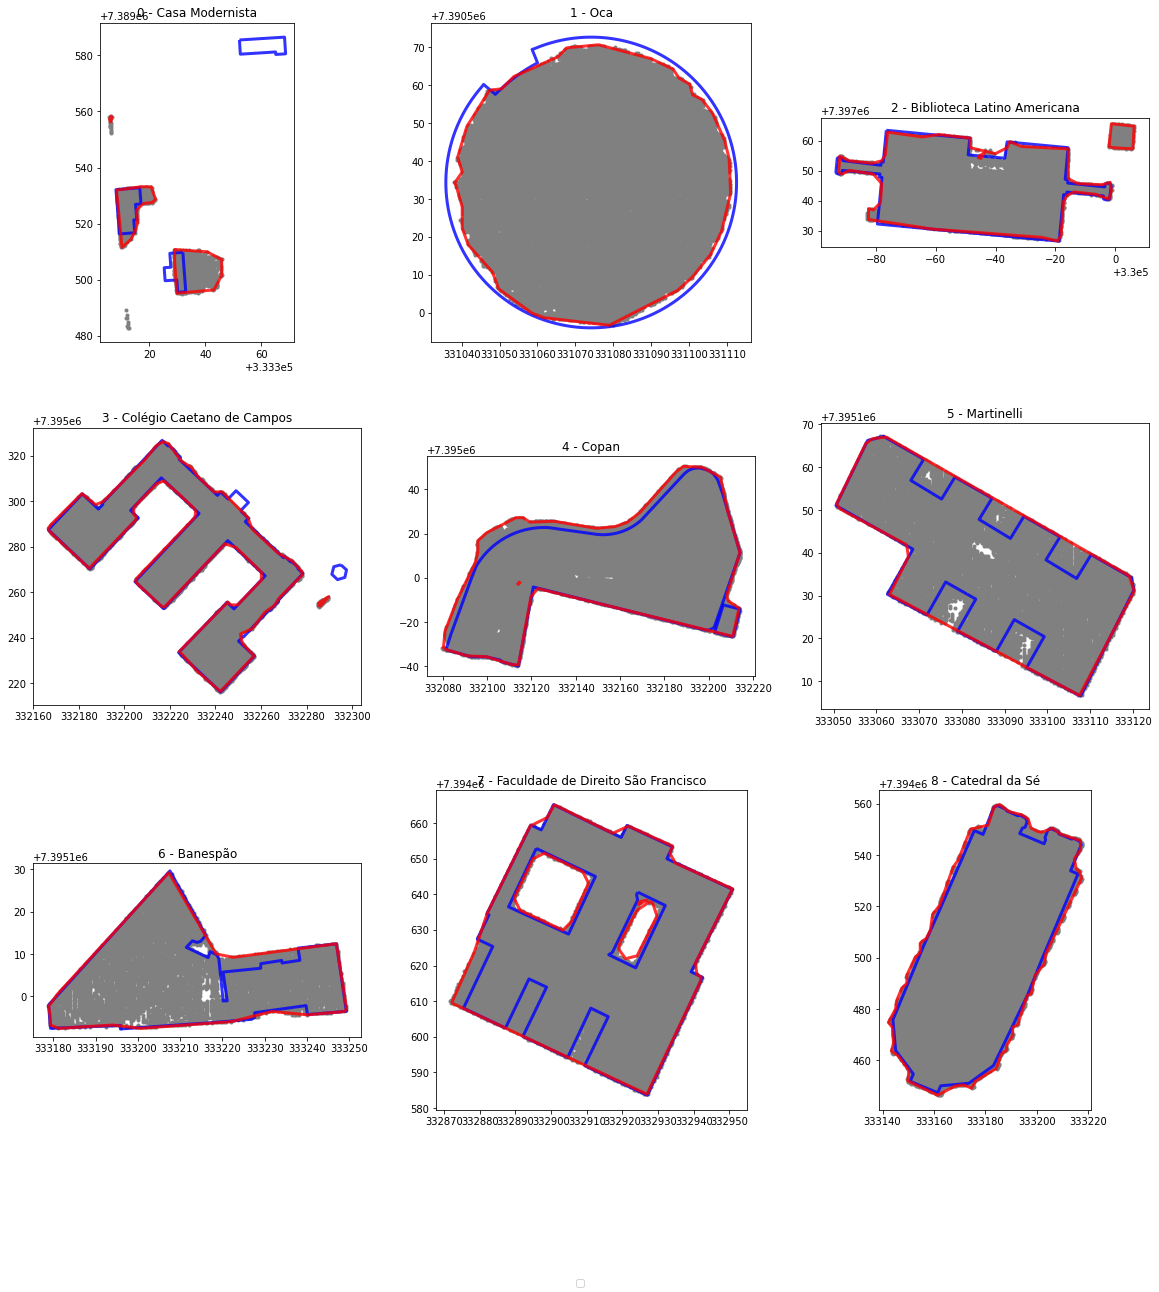

time: 9.29 s


In [123]:
fig = plt.figure(figsize=(20,20))

i = 0 
for l in range(3):
    for c in range(3):
        ax = plt.subplot2grid((3,3), (l,c))
        gpd_avaliacoes[gpd_avaliacoes.AreaID == i].plot(edgecolor='red', color=None, ax=ax, facecolor="none", lw=3, zorder=3, alpha=0.8)
        gpd.GeoDataFrame(geometry=[cascaded_union(cadastro_2004[cadastro_2004.loc_id == i+1].geometry)]).plot(edgecolor='blue', color=None, ax=ax, facecolor="none", lw=3, alpha=0.8, zorder=2)
        gpd_points[gpd_points.AreaID == i].plot(ax=ax, lw=1, color='grey', alpha=1, marker='.')
        ax.title.set_text(f'{i} - {areas_estudo.iloc[i].Nome}')
        i += 1

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center')
plt.show()


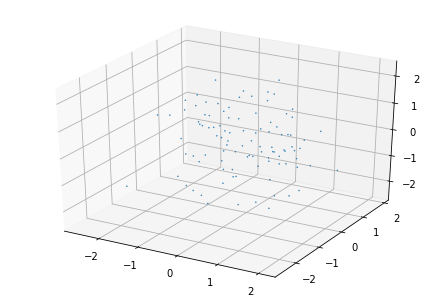

time: 118 ms


In [119]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
N = 100
data = np.random.randn(N, 3)
x,y,z = data[:,0:3].T
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z, s=1, alpha=1, marker='.')

[[(0, 0, 0), (1, 0, 1), (1, 1, 0), (0, 1, 1)]]


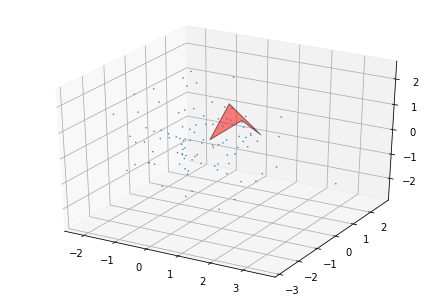

time: 124 ms


In [141]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [0,1,1,0]
y = [0,0,1,1]
z = [0,1,0,1]
verts = [list(zip(x,y,z))]
print(verts)

ax.add_collection3d(Poly3DCollection(verts, color='red', alpha=0.5, edgecolor='black'))

N = 100
data = np.random.randn(N, 3)
x,y,z = data[:,0:3].T
# fig = plt.figure()
# ax = Axes3D(fig)
ax.scatter(x, y, z, s=1, alpha=1, marker='.')
plt.show()

/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead
  
/home/fernando/miniconda3/envs/pcp-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.rand is deprecated and will be removed in SciPy 2.0.0, use numpy.random.rand instead
  # Remove the CWD from sys.path while we load stuff.


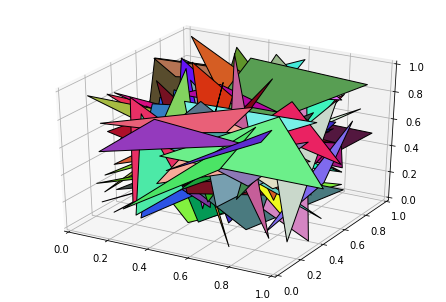

time: 250 ms


In [139]:
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import pylab as pl
import scipy as sp

ax = a3.Axes3D(pl.figure())
for i in range(100):
    vtx = sp.rand(3,3)
    tri = a3.art3d.Poly3DCollection([vtx])
    tri.set_color(colors.rgb2hex(sp.rand(3)))
    tri.set_edgecolor('k')
    ax.add_collection3d(tri)
pl.show()